<a href="https://colab.research.google.com/github/teamsimcoemmai/mmai894/blob/main/Final%20Project/Mish_EfficientNet_B3_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install fastai
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from collections import Counter

In [ ]:
import random
import os
import pandas as pd
import scipy.io as sio
import numpy as np

import shutil
from shutil import copyfile

import cv2 as cv

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.preprocessing import image_dataset_from_directory

# from keras.datasets import cifar10
# from keras.utils import np_utils
# from keras.models import Sequential
# from keras.layers.core import Dense
# from keras.optimizers import SGD

In [ ]:
!pip install --upgrade efficientnet-pytorch
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
os.chdir("./Ranger-Deep-Learning-Optimizer")
!pip install -e . 

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=8b881b6d1581a56b2e7e9b2122e704cfd6b0e8e296faa9da5e736c5465501636
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
Cloning into 'Ranger-Deep-Learning-Optimizer'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 135 (delta 34), reused 19 (delta 6), pack-reused 69
Receiving objects: 100% (135/135), 181.12 KiB | 2.32 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Obtaining file:///content/Ranger-Deep-Learning-Optimizer
  Running setup.py develop for ranger


In [ ]:
from ranger import Ranger  # this is from ranger.py
from ranger import RangerVA  # this is from ranger913A.py
from ranger import RangerQH  # this is from rangerqh.py

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Choose work directory

In [ ]:
labels_df = pd.read_csv('/content/drive/MyDrive/Simcoe/894/Car dataset/labels_df.csv')
labels_df.head(3)

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,is_test
0,000001.jpg,112,7,853,717,1,AM General Hummer SUV 2000,0
1,000002.jpg,48,24,441,202,1,AM General Hummer SUV 2000,0
2,000003.jpg,7,4,277,180,1,AM General Hummer SUV 2000,0


In [ ]:
def random_seed(seed_value, use_cuda):  #gleaned from multiple forum posts
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: torch.cuda.manual_seed_all(seed_value) # gpu 


random_seed(42,True)

data = ImageDataBunch.from_folder('/content/drive/MyDrive/Simcoe/894/Car dataset/new','train_set','val_set','test_set',
                                           ds_tfms=get_transforms(do_flip=False, 
                                                                  flip_vert=True, 
                                                                  p_affine=0.75, # Default value
                                                                  max_rotate=5.0, 
                                                                  max_zoom=1.1,
                                                                  max_warp=0.2,
                                                                  p_lighting=0.75, # Defalut value 
                                                                  max_lighting=0.2,                                                                                                                  ),
                                                                  size=224,
                                                                  bs=32).normalize(imagenet_stats)

In [ ]:
from efficientnet_pytorch import EfficientNet as MEfficientNet

effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(1536, data.c)
    return model

mish_model = getMishModel(data, effnet_b3) 

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


In [ ]:
# By @muellerzr on the fastai forums:
# https://forums.fast.ai/t/meet-mish-new-activation-function-possible-successor-to-relu/53299/133       

from fastai.callbacks import *

def FlatCosAnnealScheduler(learn, lr:float=4e-3, tot_epochs:int=1, moms:Floats=(0.95,0.999),
                          start_pct:float=0.72, curve='cosine'):
    "Manage FCFit trainnig as found in the ImageNette experiments"
    n = len(learn.data.train_dl)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":
        curve_type=annealing_cos
    elif curve=="linear":
        curve_type=annealing_linear
    elif curve=="exponential":
        curve_type=annealing_exp
    else:
        raiseValueError(f"annealing type not supported {curve}")

    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr).schedule_hp('mom', moms[0])
    phase1 = TrainingPhase(batch_finish).schedule_hp('lr', lr, anneal=curve_type).schedule_hp('mom', moms[1])
    phases = [phase0, phase1]
    return GeneralScheduler(learn, phases)
                
def fit_fc(learn:Learner, tot_epochs:int=None, lr:float=defaults.lr,  moms:Tuple[float,float]=(0.95,0.85), start_pct:float=0.72,
                  wd:float=None, callbacks:Optional[CallbackList]=None, show_curve:bool=False)->None:
    "Fit a model with Flat Cosine Annealing"
    max_lr = learn.lr_range(lr)
    callbacks = listify(callbacks)
    callbacks.append(FlatCosAnnealScheduler(learn, lr, moms=moms, start_pct=start_pct, tot_epochs=tot_epochs))
    learn.fit(tot_epochs, max_lr, wd=wd, callbacks=callbacks)

In [ ]:
def save_metrics_to_csv(exp_name, run_count, learn, metrics):
    for m in metrics:
        name = f'{m}_{exp_name}_run{str(run_count)}_2021-03_31'

        ls = []
        if m == 'val_loss_and_acc':
            acc = []
            for l in learn.recorder.metrics:
                 acc.append(l[0].item())
            ls = learn.recorder.val_losses 

            d = {name: ls, 'acc': acc}
            df = pd.DataFrame(d)
            #df.columns = [name, 'acc']
        elif m == 'trn_loss':
            for l in learn.recorder.losses:
                ls.append(l.item())
            df = pd.DataFrame(ls)
            df.columns = [name]

        df.to_csv(f'{name}_{m}.csv')
        print(df.head())

In [ ]:
optimizer = partial(Ranger)
exp_name = 'exp_mefficient_b3_ranger_run1'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data, 
                model=mish_model,
                wd = 1e-3,
                opt_func=optimizer,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=30, lr=15e-4, start_pct=0.10, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,accuracy,time
0,2.759998,2.189952,0.616969,59:54
1,1.599218,1.501207,0.814662,02:30
2,1.354032,1.374668,0.859967,02:31
3,1.275309,1.386340,0.857084,02:31
4,1.218143,1.360959,0.863262,02:31
5,1.144873,1.275076,0.892916,02:32
6,1.156337,1.450574,0.851730,02:31
7,1.100023,1.286939,0.889209,02:31
8,1.091774,1.251568,0.901153,02:31
9,1.039459,1.231757,0.906507,02:32


   trn_loss_exp_mefficient_b3_ranger_run1_run1_2021-03_31
0                                           5.325540     
1                                           5.300922     
2                                           5.283120     
3                                           5.273282     
4                                           5.268210     
   val_loss_and_acc_exp_mefficient_b3_ranger_run1_run1_2021-03_31       acc
0                                           2.189952               0.616969
1                                           1.501207               0.814662
2                                           1.374668               0.859967
3                                           1.386340               0.857084
4                                           1.360959               0.863262


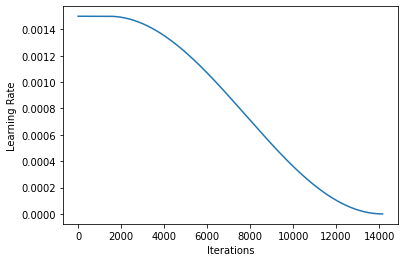

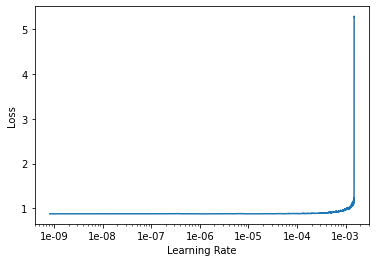

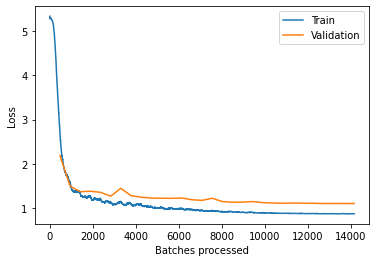

In [ ]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

In [ ]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 226, 226]        0          False     
______________________________________________________________________
BatchNorm2d          [40, 112, 112]       80         True      
______________________________________________________________________
ZeroPad2d            [40, 114, 114]       0          False     
______________________________________________________________________
BatchNorm2d          [40, 112, 112]       80         True      
______________________________________________________________________
Identity             [40, 1, 1]           0          False     
______________________________________________________________________
Identity             [10, 1, 1]           0          False     
______________________________________________________________________
Identity             [40, 112, 112]       0          False     
_________________________________________________

# **Test**

In [ ]:
# Initialize and load trained model

optimizer = partial(Ranger)
exp_name = 'Efficient_Test'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data, 
                model=mish_model,
                wd = 1e-3,
                opt_func=optimizer,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

learn.load('/content/drive/MyDrive/Simcoe/894/Car dataset/new/models/exp_mefficient_b3_ranger_run1')

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
set state called


Learner(data=ImageDataBunch;

Train: LabelList (11330 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
152,152,152,152,152
Path: /content/drive/MyDrive/Simcoe/894/Car dataset/new;

Valid: LabelList (2428 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
192,192,192,192,192
Path: /content/drive/MyDrive/Simcoe/894/Car dataset/new;

Test: LabelList (2427 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/Simcoe/894/Car dataset/new, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track

# Test with single image and create loop to calculate test accuracy

In [ ]:
tst_labels_df = labels_df.loc[labels_df['is_test']==1, ['filename','class_id']].copy()
tst_labels_df

,filename,class_id
45,000046.jpg,1
46,000047.jpg,1
47,000048.jpg,1
48,000049.jpg,1
49,000050.jpg,1
...,...,...
16180,016181.jpg,196
16181,016182.jpg,196
16182,016183.jpg,196
16183,016184.jpg,196


In [ ]:
tst_labels_df = tst_labels_df.set_index('filename')
num_image_index = tst_labels_df.index
num_image_index = np.asarray(num_image_index)
num_image_index

array(['000046.jpg', '000047.jpg', '000048.jpg', '000049.jpg', ..., '016182.jpg', '016183.jpg', '016184.jpg',
       '016185.jpg'], dtype=object)

In [ ]:
test_set_path = "/content/drive/My Drive/Simcoe/894/Car dataset/cropped_raw/"

preds = []
dataIndex = []
num_preds = num_image_index
for i in num_image_index:
    image_file_name = i
    test_image_path = test_set_path + image_file_name
    p = learn.predict(open_image(test_image_path))
    preds.append(str(p[0]))
    dataIndex.append(str(i))

In [ ]:
dataIndex1 = np.asarray(dataIndex)
preds = list(map(int, preds))
pred_tup = list(zip(dataIndex1,preds))
pred_tup.sort()

df_test_new = tst_labels_df
actual_tup = df_test_new[['class_id']].to_records(index=False)
actual_tup = list(actual_tup)

df_pred = pd.DataFrame(pred_tup,columns=['filename','pred_class'])

df_valid = df_test_new.merge(df_pred, left_on = 'filename', right_on = 'filename' )

feature_list1 = ['filename','class_id','pred_class']
df_valid1 = df_valid[feature_list1]
df_valid1

df_valid1['diff'] = np.where(df_valid1['class_id'] == df_valid1['pred_class'],1,0)
accuracy = df_valid1['diff'].sum()/df_valid1.shape[0]*100

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(df_valid1['class_id'].values, df_valid1['pred_class'].values, average = 'weighted')
print('The precision score is', precision, '\nThe recall score is', recall, '\nThe fscore score is', fscore, '\nThe accuracy score is', accuracy)

The precision score is 0.9814618139877337 
The recall score is 0.9810968784976993 
The fscore score is 0.9810684564370845 
The accuracy score is 98.10968784976993


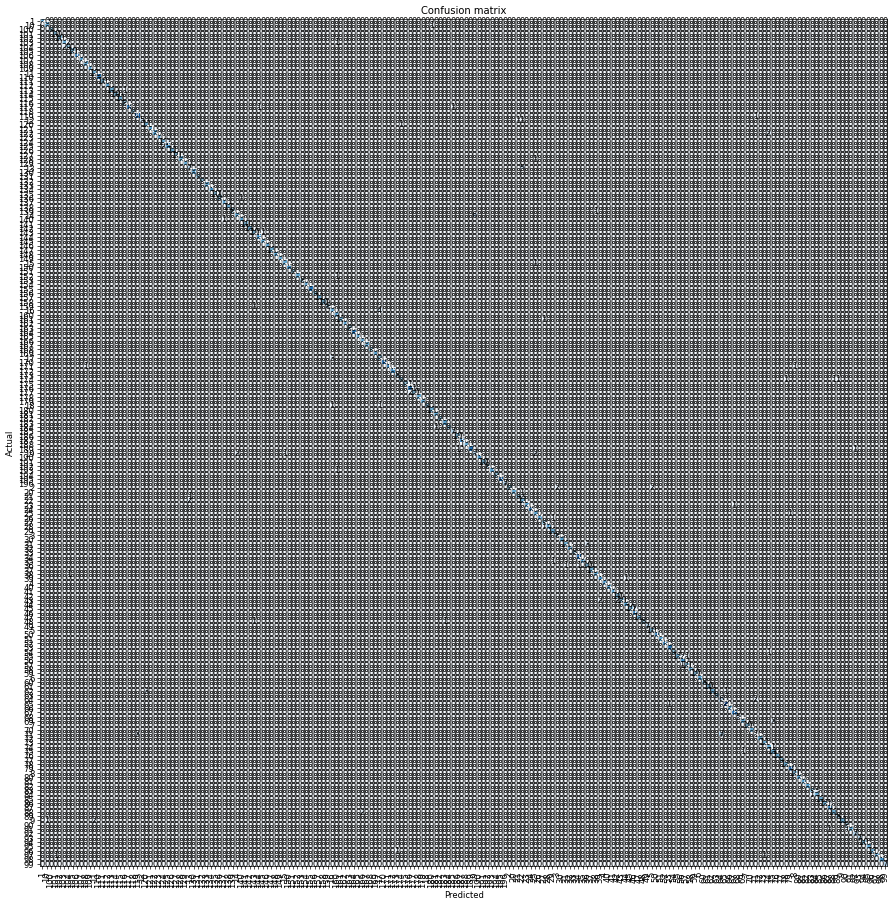

In [ ]:
random_seed(42,True)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (15, 15), dpi = 60)